# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y, Derive New Columns and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

### 2.1 Create X, y

In [4]:
data['circle_id'].unique()

array([109])

In [5]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 170), (69999,))

In [6]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [7]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [8]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

### Removing columns - which have little/ no variation


In [9]:
# Dropping date columns, which don't appear to contribute to the results and are not numerical variables
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = data.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 162), (69999,))

In [10]:
# Dropping columns that only have a single value, and does not contribute to the results
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'circle_id': 1, 'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [11]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape


(69999, 152)

<Axes: >

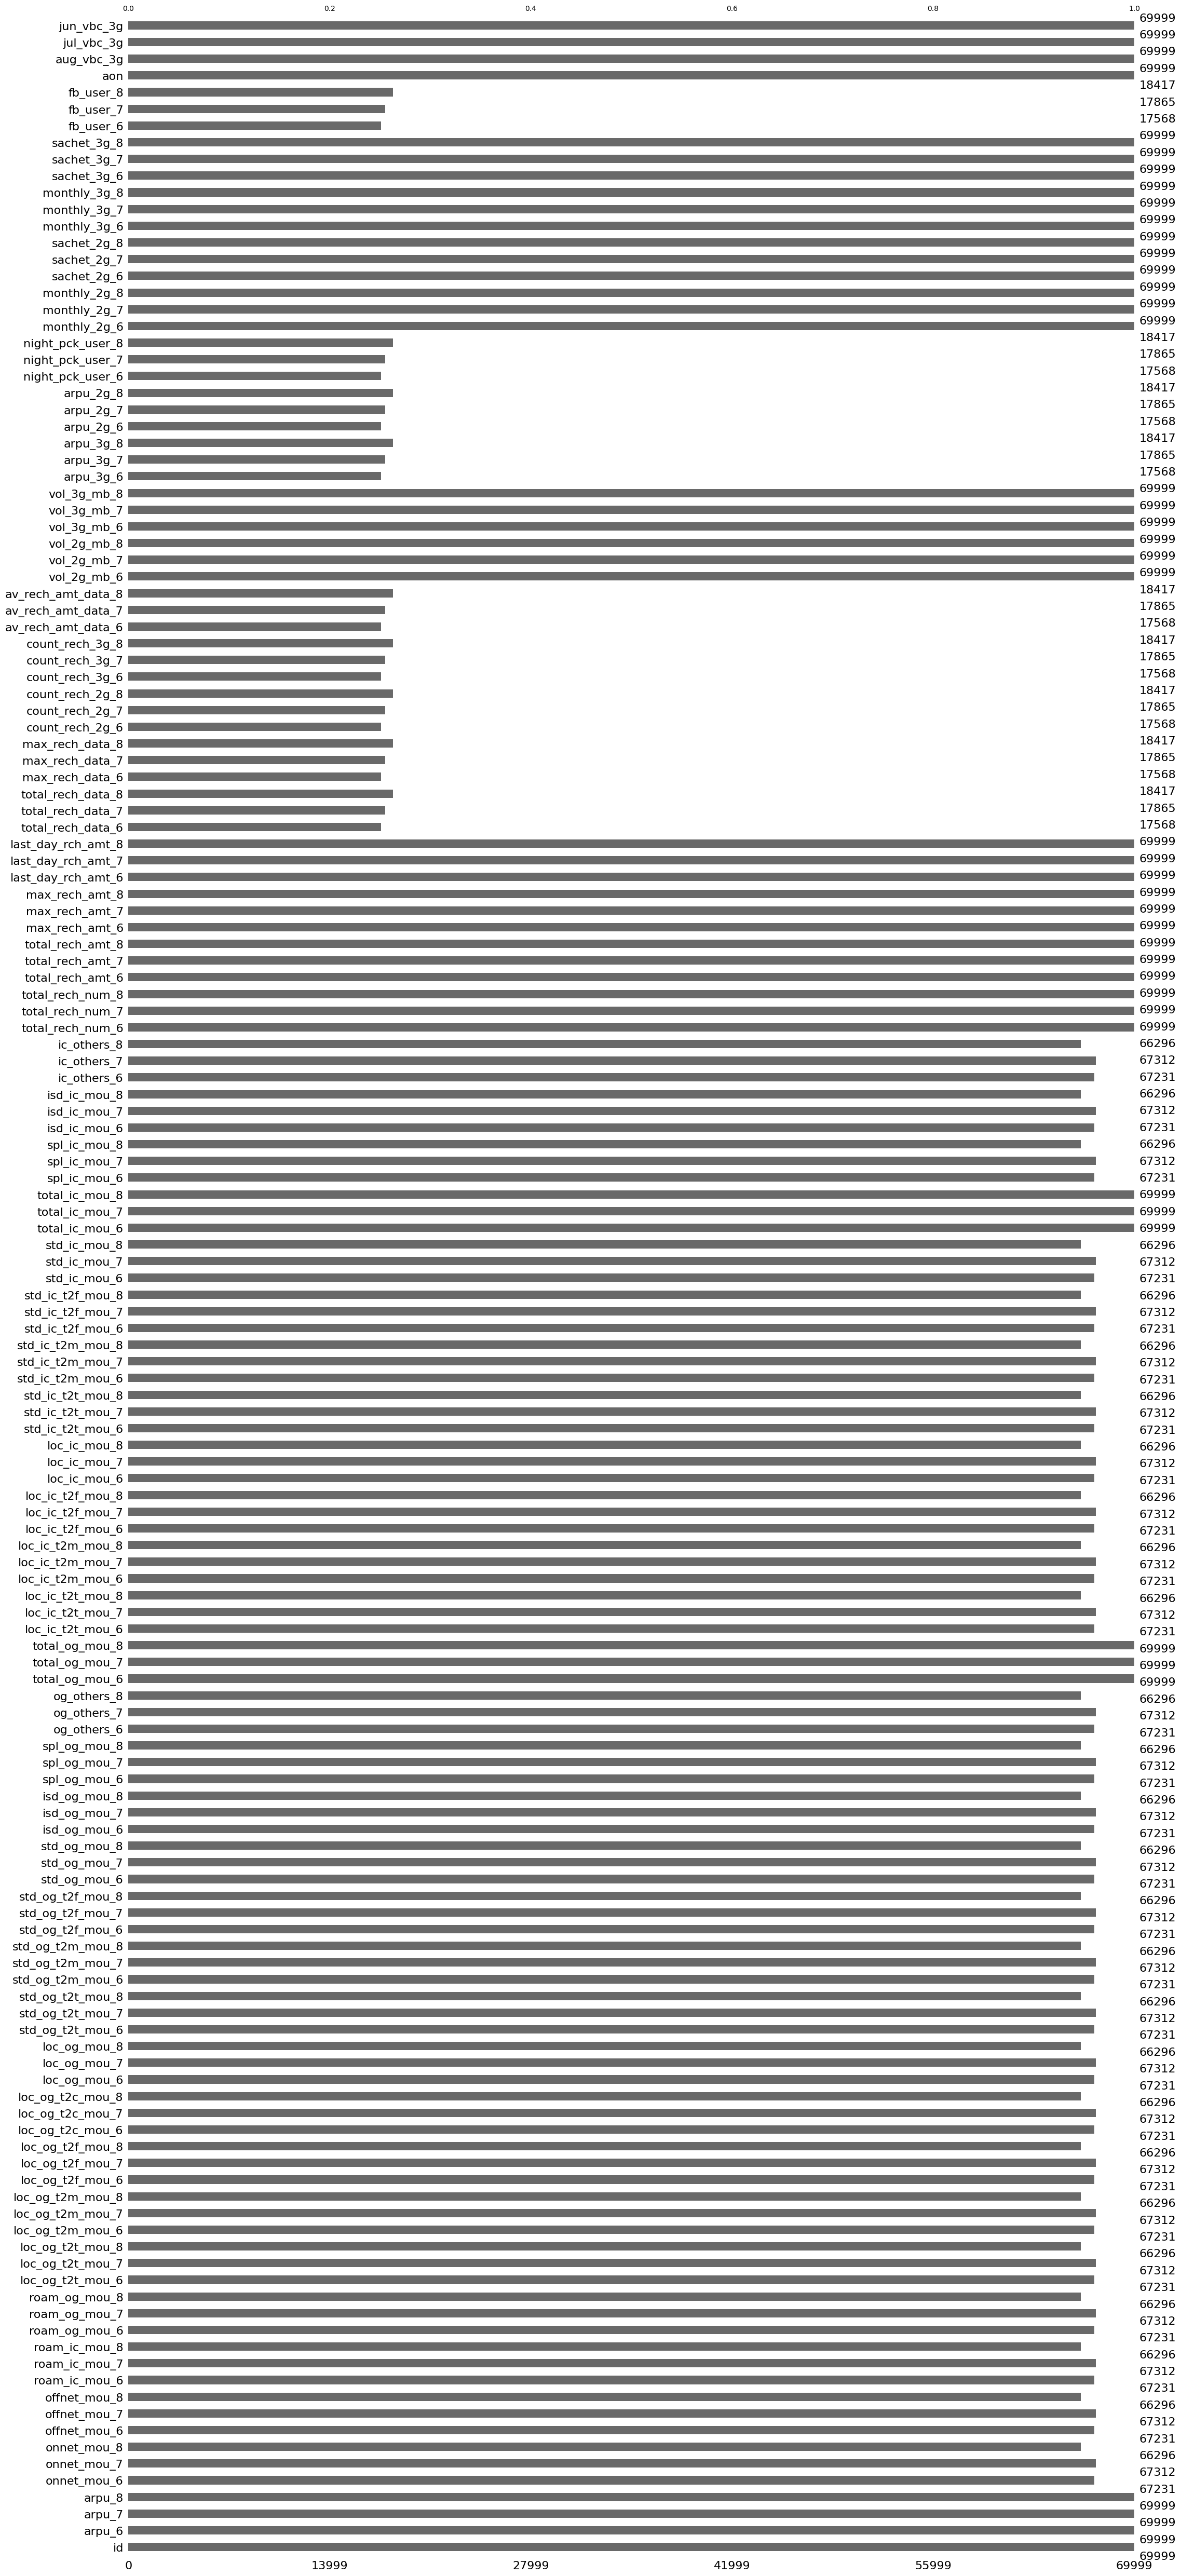

In [12]:
msno.bar(X)

In [13]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
jun_vbc_3g      0.000000
Length: 152, dtype: float64

In [14]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [15]:
X_filtered = X[new_vars]
X_filtered.shape

(69999, 125)

In [16]:
print(X_filtered.shape)
print(y.shape)


(69999, 125)
(69999,)


In [17]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 125)
Shape of y: (69999,)


## 2.2 Deriving New Feature Columns 

We noticed that while there are a series of colulmns related to the same type of variable, there is no variable which explains the percentage increase or decrese over that time period. Consequentlyh we are proposing to add a few new columns for 

- Average change in revenue per user across months 6,7,8 (arpu_6, arpu_7, arpu_8)
- Average change in all kinds of calls within the same operator network for months 6,7,8 (onnet_mou_6, onnet_mou_7, onnet_mou_8)
- Average change in all kinds of calls outside the same operator network for months 6,7,8 (offnet_mou_6, offnet_mou_7, offnet_mou_8)




### Deriving new columns for average changes in revenue across months 6,7,8 (arpu_6, arpu_7, arpu_8)
Calculate the change in revenue between months:

From month 6 to month 7 (arpu_7 - arpu_6)
From month 7 to month 8 (arpu_8 - arpu_7)
Take the average of these two changes to create a new derived col


In [18]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 125)
Shape of y: (69999,)


In [19]:
# Calculate the average absolute change in revenue
X_filtered['avg_absolute_change_revenue'] = (
    (X_filtered['arpu_7'] - X_filtered['arpu_6']) +
    (X_filtered['arpu_8'] - X_filtered['arpu_7'])
) / 2

# Calculate the average percentage change in revenue
X_filtered['avg_percentage_change_revenue'] = (
    ((X_filtered['arpu_7'] - X_filtered['arpu_6']) / X_filtered['arpu_6']) +
    ((X_filtered['arpu_8'] - X_filtered['arpu_7']) / X_filtered['arpu_7'])
) / 2


In [20]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


In [21]:
X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe()


avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf

In [22]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


In [23]:
# # Replace inf, -inf, and NaN with NaN (for consistency)
# X_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].replace([float('inf'), -float('inf')], float('nan'))

# # Drop rows with NaN in avg_percentage_change_revenue
# X_filtered = X_filtered.dropna(subset=['avg_percentage_change_revenue'])

# Recompute the mean and describe
print(X_filtered['avg_percentage_change_revenue'].mean())
print(X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe())


nan
       avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf


In [24]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


### Deriving a new column for average change in all kinds of calls within the same operator network 

In [25]:
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].describe()

onnet_mou_6   onnet_mou_7   onnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     133.153275    133.894438    132.978257
std      299.963093    311.277193    311.896596
min        0.000000      0.000000      0.000000
25%        7.410000      6.675000      6.410000
50%       34.110000     32.280000     32.100000
75%      119.390000    115.837500    115.060000
max     7376.710000   8157.780000  10752.560000

In [26]:
# Replace missing values with 0 or any other appropriate default
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']] = \
    X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].fillna(0)


In [27]:
# Calculate the average change in on-net minutes of usage
X_filtered['avg_change_onnet_mou'] = (
    (X_filtered['onnet_mou_7'] - X_filtered['onnet_mou_6']) +
    (X_filtered['onnet_mou_8'] - X_filtered['onnet_mou_7'])
) / 2


In [28]:
print(X_filtered['avg_change_onnet_mou'].describe())


count    69999.000000
mean        -0.972166
std        134.971400
min      -3411.600000
25%        -12.680000
50%          0.000000
75%         10.235000
max       3395.190000
Name: avg_change_onnet_mou, dtype: float64


In [29]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 128)
Shape of y: (69999,)


### Deriving a new column for average change in all kinds of calls outside the operator network 

In [30]:
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].describe()

offnet_mou_6  offnet_mou_7  offnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     198.874771    197.153383    196.543577
std      316.818355    322.482226    324.089234
min        0.000000      0.000000      0.000000
25%       34.860000     32.240000     31.575000
50%       96.480000     91.885000     91.800000
75%      232.990000    227.630000    229.345000
max     8362.360000   7043.980000  14007.340000

In [31]:
# Calculate the average change in off-net minutes of usage
X_filtered['avg_change_offnet_mou'] = (
    (X_filtered['offnet_mou_7'] - X_filtered['offnet_mou_6']) +
    (X_filtered['offnet_mou_8'] - X_filtered['offnet_mou_7'])
) / 2


In [32]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 129)
Shape of y: (69999,)


In [33]:
# Replace missing values with 0 or another appropriate value
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']] = \
    X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].fillna(0)


In [34]:
print(X_filtered['avg_change_offnet_mou'].describe())


count    63842.000000
mean        -1.165819
std        141.760274
min      -4166.000000
25%        -27.360000
50%         -0.520000
75%         23.388750
max       6887.525000
Name: avg_change_offnet_mou, dtype: float64


## 2.3 Train Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((55999, 129), (14000, 129), (55999,), (14000,))

In [36]:
X_train.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
40151  40151  108.208  133.066  359.323        12.41        18.98   
580      580  225.510  317.162  313.344        76.64       126.16   
31613  31613   29.255  101.752  360.463        11.04        12.03   
10428  10428   -5.000  518.882  537.677         0.00       564.18   
51502  51502  610.774  637.067    0.000       993.18       702.88   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
40151        50.24         85.26         93.53        279.86  ...   
580         142.16        127.26        288.94        248.94  ...   
31613        22.98         14.29         72.86        167.89  ...   
10428       735.28          0.00        423.44        306.18  ...   
51502         0.00        340.88        437.41          0.00  ...   

       sachet_3g_7  sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
40151            0            0   679        0.00         0.0         0.0   
580              0            0  2224        0.00         0.0         0.0   
31613            0            0  1364        0.00         0.0         0.0   
10428            0            0  1035        7.12         0.0         0.0   
51502            0            0   597        0.00         0.0         0.0   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
40151                     125.5575                       0.965030   
580                        43.9170                       0.197191   
31613                     165.6040                       2.510335   
10428                     271.3385                     -52.370089   
51502                    -305.3870                      -0.478476   

       avg_change_onnet_mou  avg_change_offnet_mou  
40151                18.915                  97.30  
580                  32.760                  60.84  
31613                 5.970                  76.80  
10428               367.640                    NaN  
51502              -496.590                    NaN  

[5 rows x 129 columns]

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

## 3.1 Handling Missing data - Training Set

In [37]:
print(X_train.shape)
print(y_train.shape)


(55999, 129)
(55999,)


In [38]:
# Display the data types of each column
print(X_train.dtypes)


id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [39]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [40]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')

In [41]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 129)
(69999,)


<Axes: >

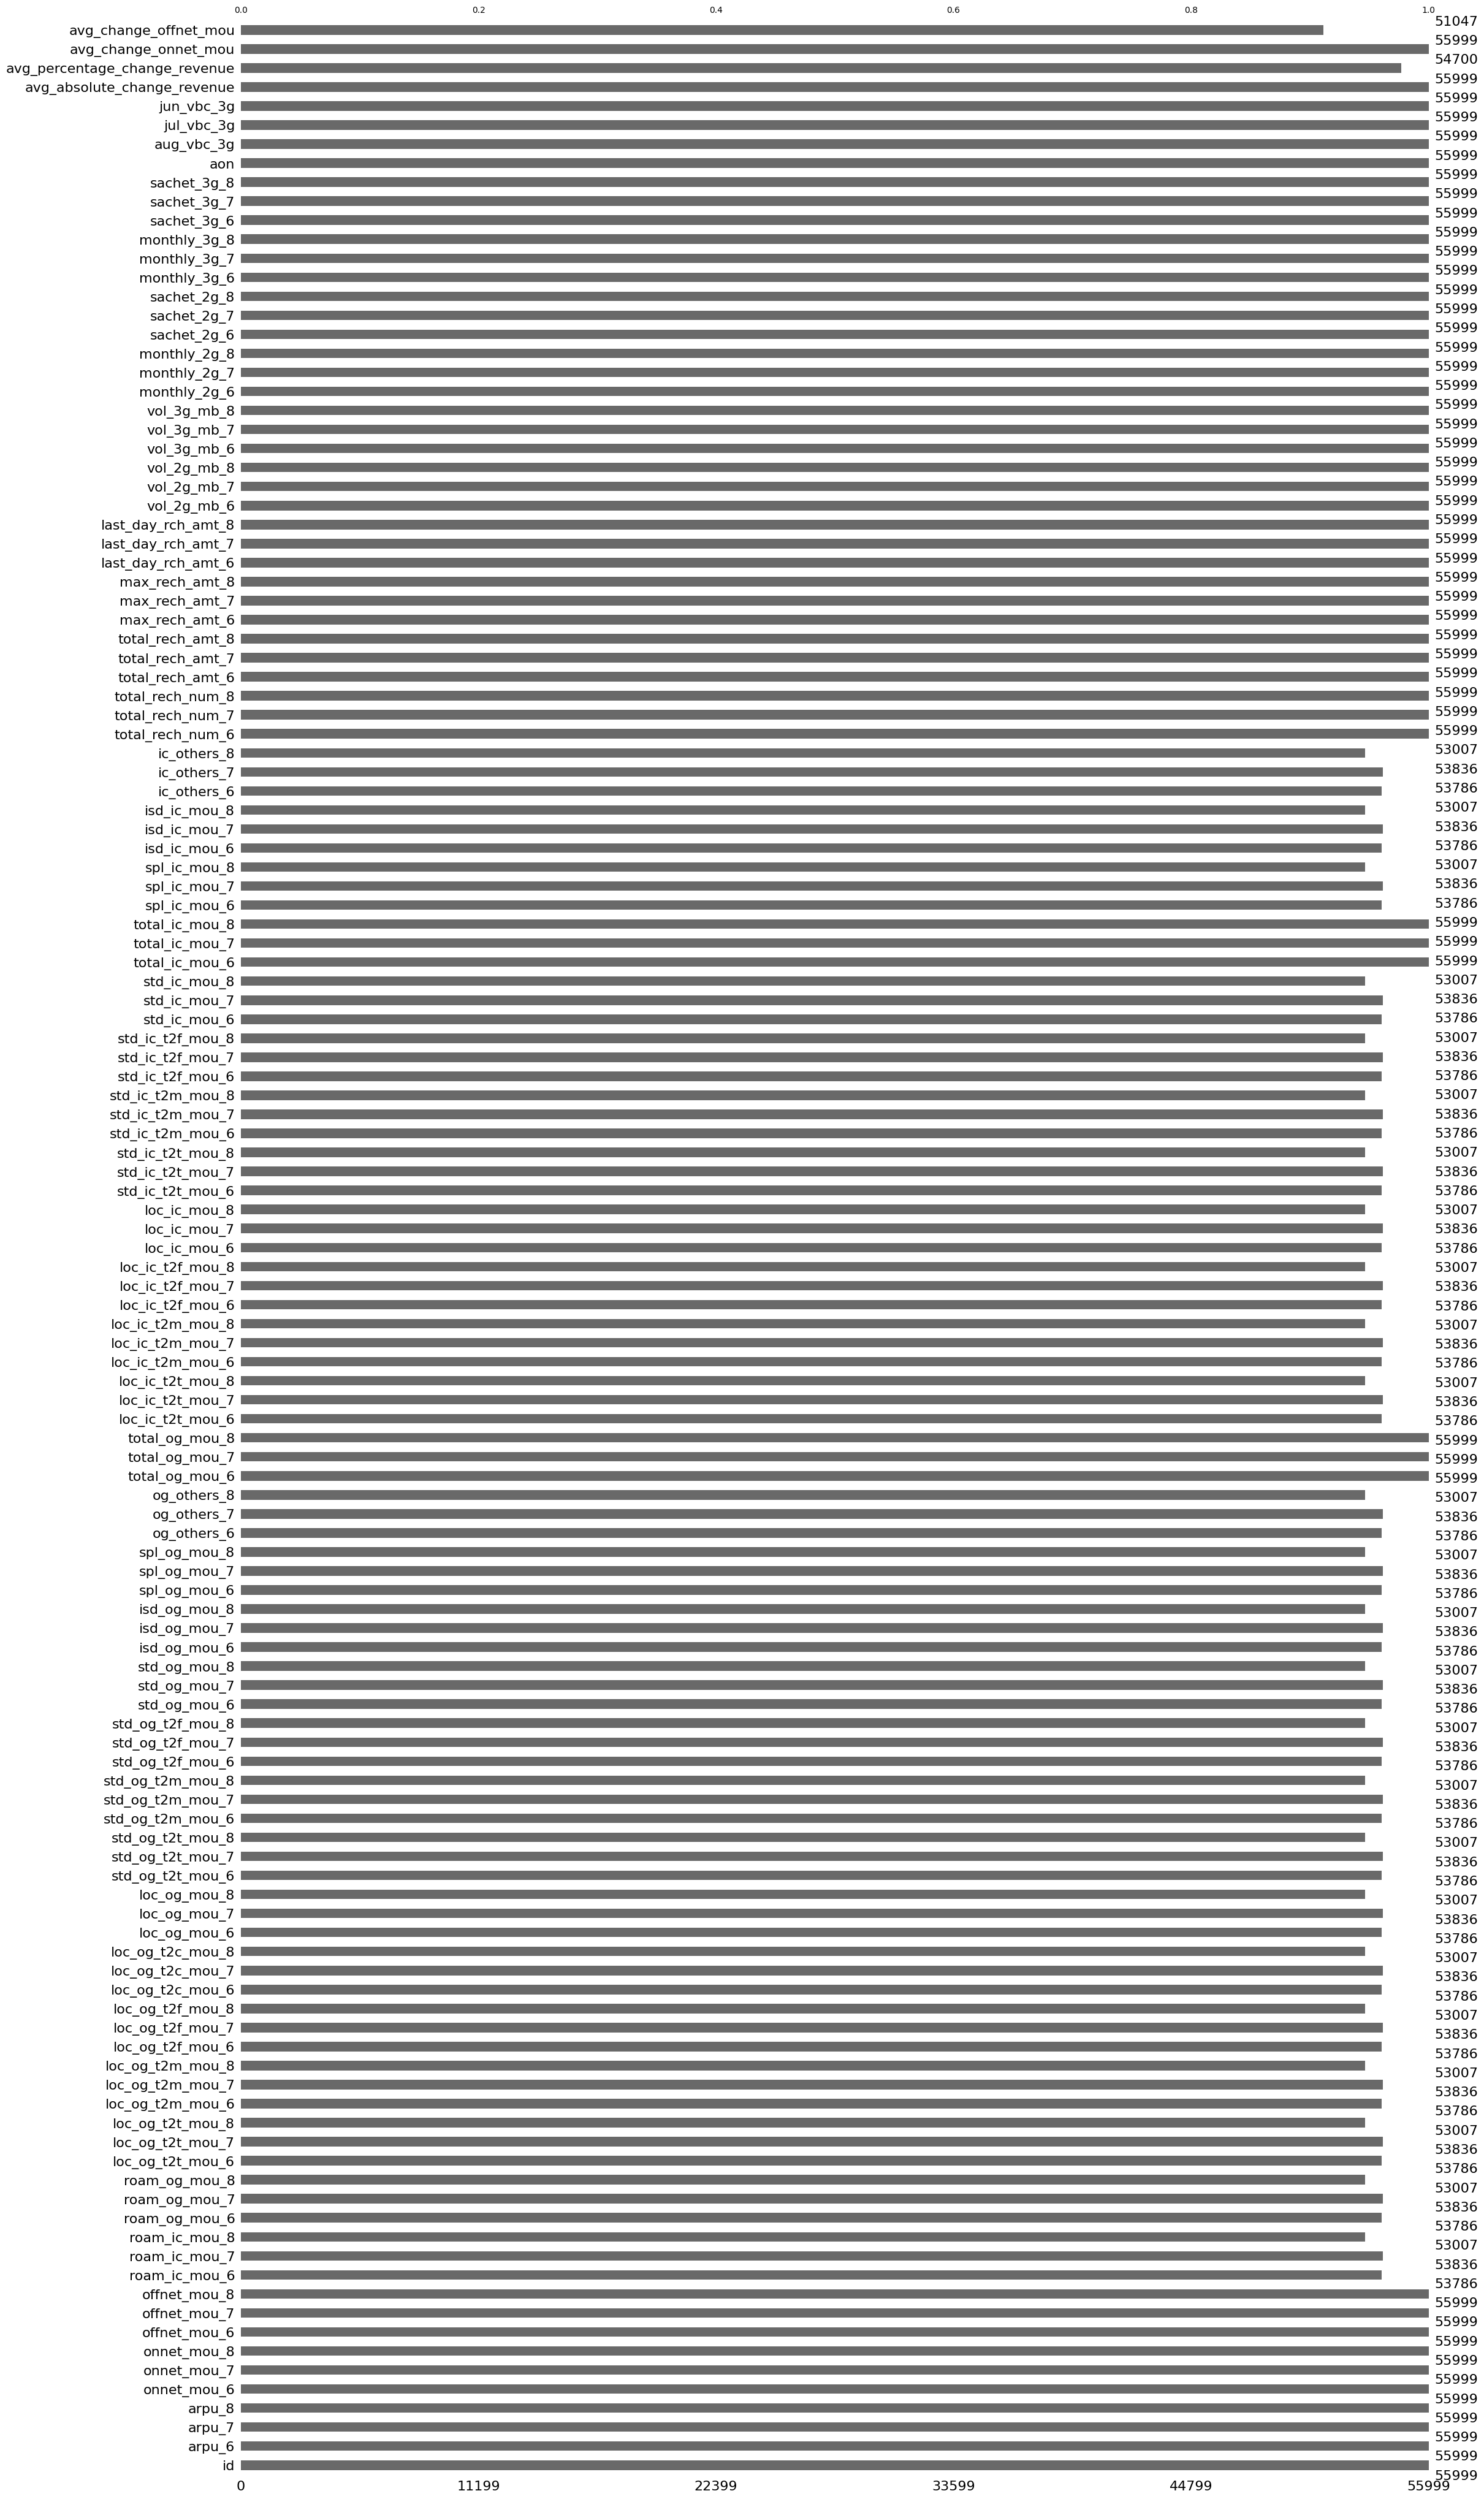

In [42]:
msno.bar(X_train)

In [43]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [44]:
# Check for infinite values
print(np.isinf(X_train_filtered).sum())

# Check for very large values
print((X_train_filtered.abs() > 1e308).sum())


id                                  0
arpu_6                              0
arpu_7                              0
arpu_8                              0
onnet_mou_6                         0
                                 ... 
jun_vbc_3g                          0
avg_absolute_change_revenue         0
avg_percentage_change_revenue    2511
avg_change_onnet_mou                0
avg_change_offnet_mou               0
Length: 129, dtype: int64
id                                  0
arpu_6                              0
arpu_7                              0
arpu_8                              0
onnet_mou_6                         0
                                 ... 
jun_vbc_3g                          0
avg_absolute_change_revenue         0
avg_percentage_change_revenue    2511
avg_change_onnet_mou                0
avg_change_offnet_mou               0
Length: 129, dtype: int64


In [45]:
# Replace infinity with NaN
X_train_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = X_train_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
X_train_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].fillna(median_value)


In [46]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

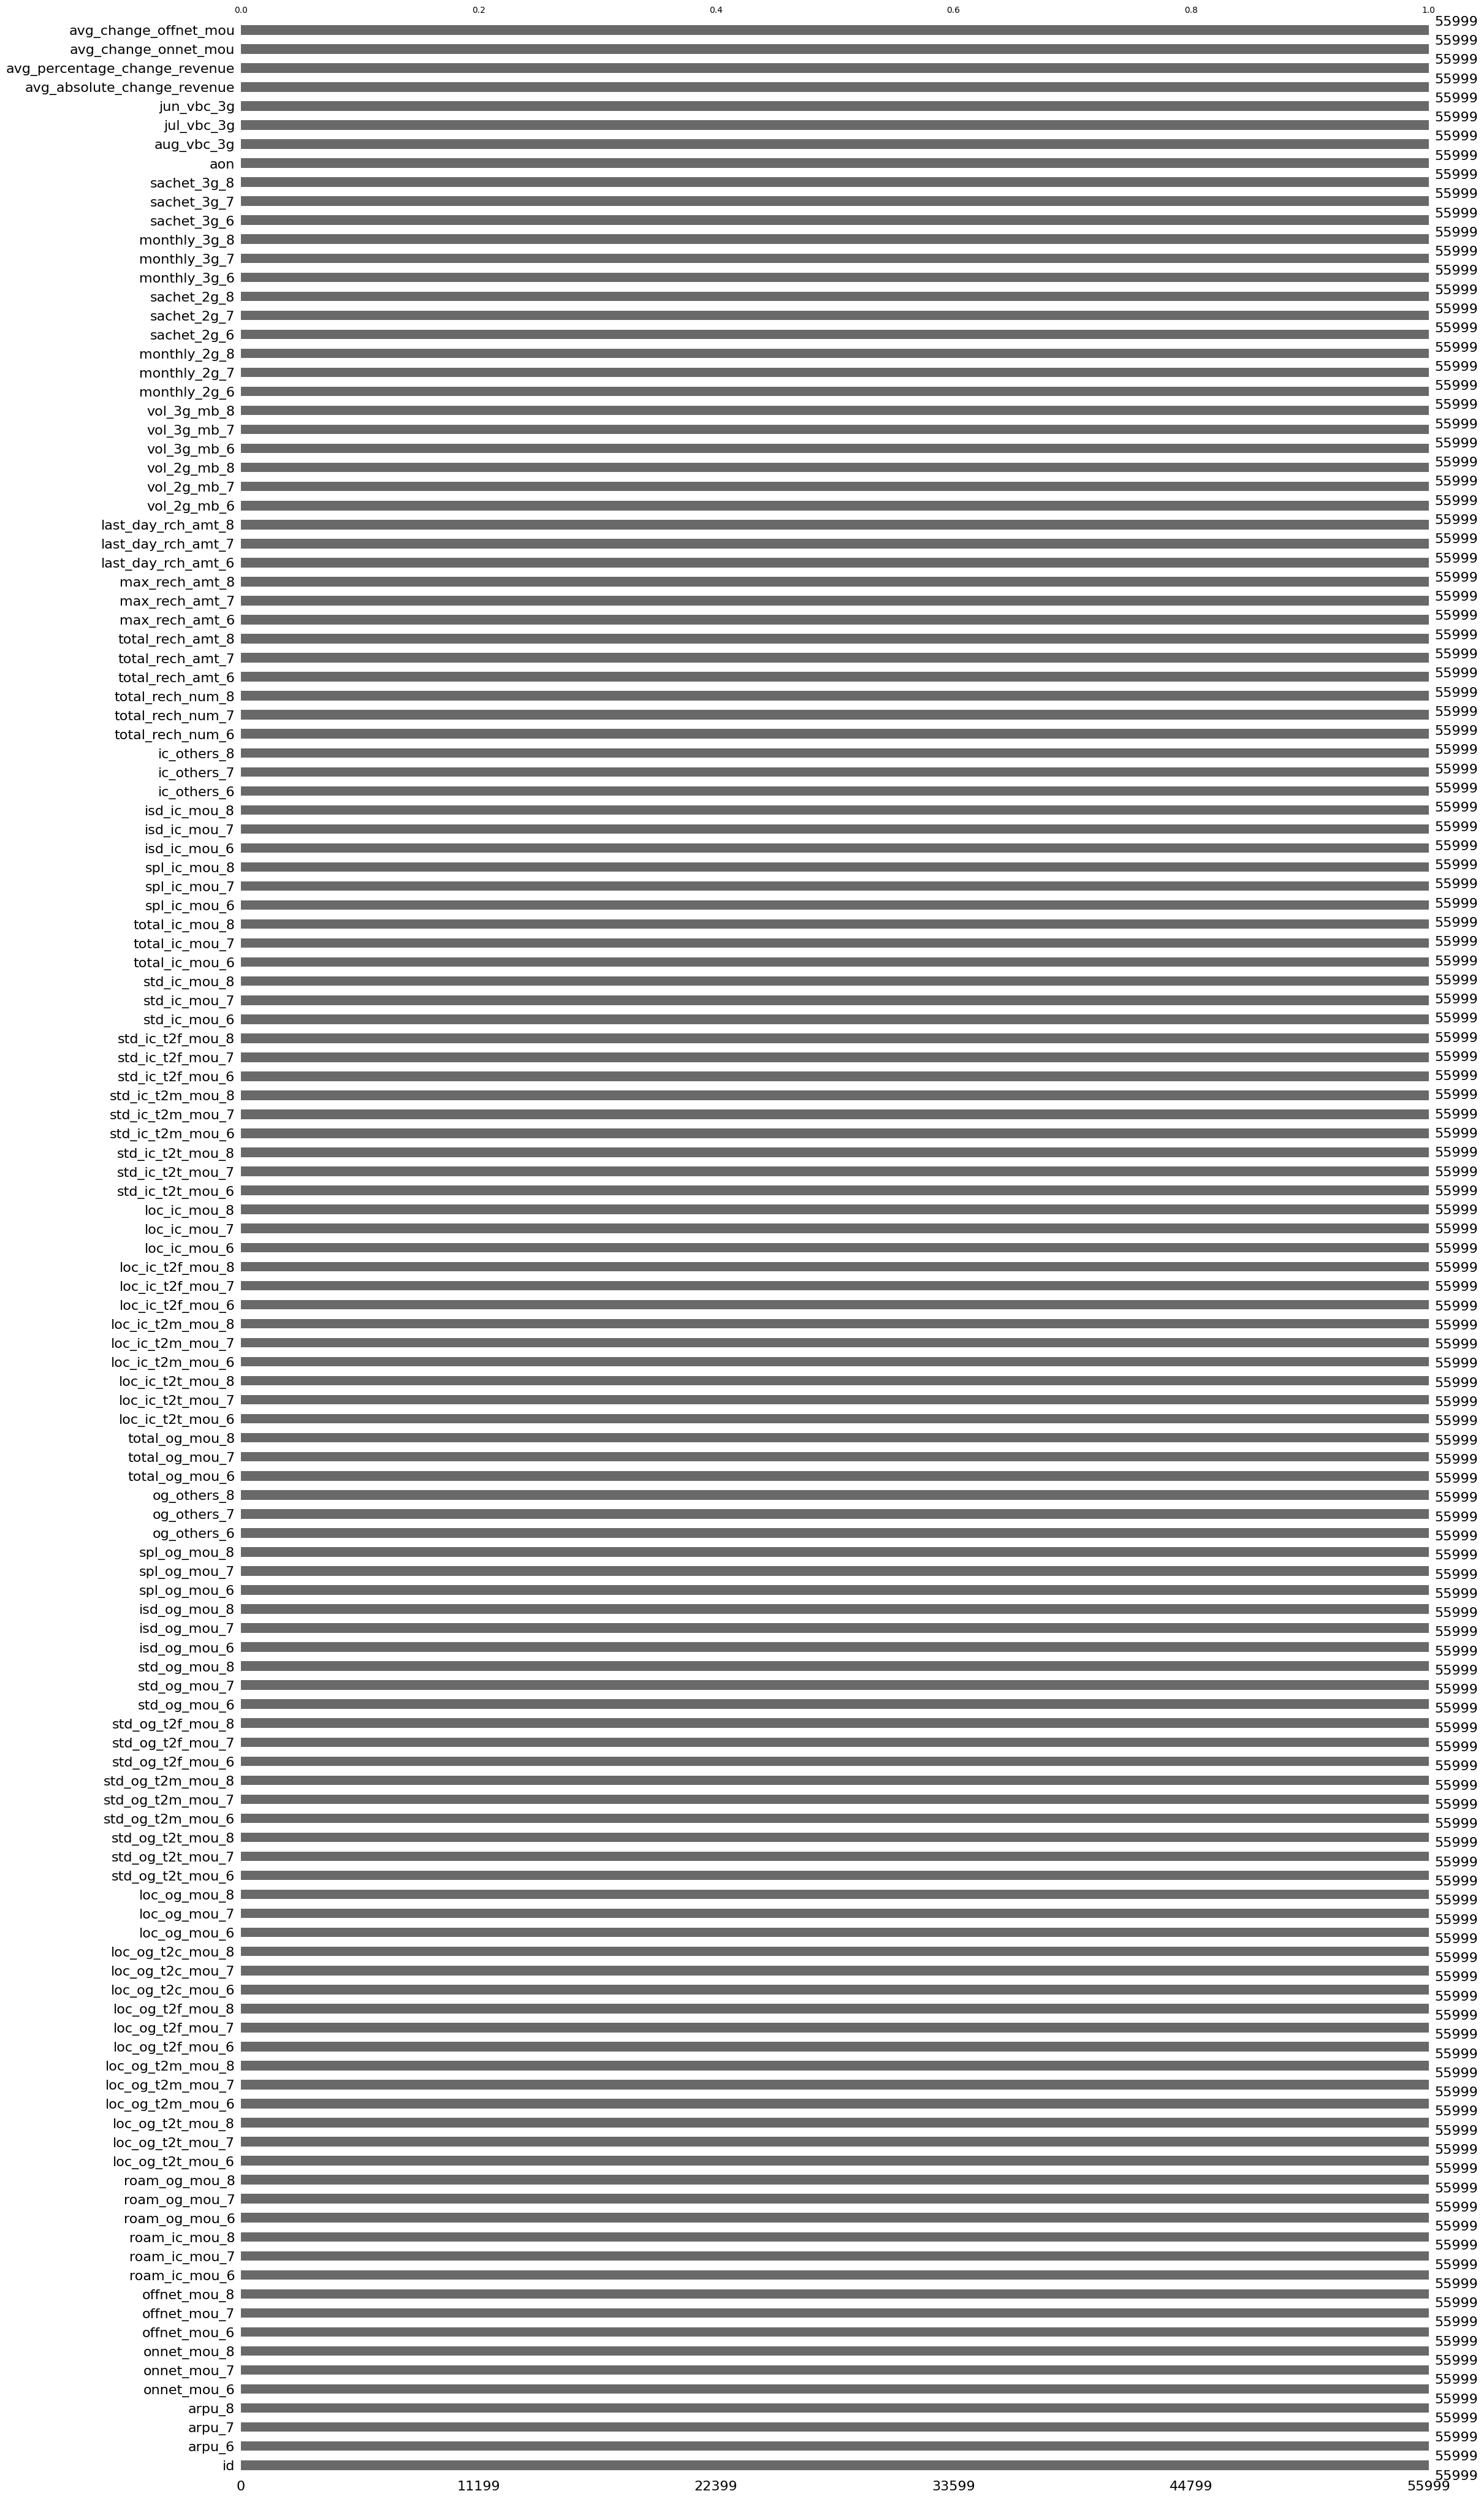

In [47]:
msno.bar(X_train_filtered)

In [48]:
print(X_train_filtered.shape)
print(y.shape)


(55999, 129)
(69999,)


In [49]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   35077.136413    283.420472    278.512006    279.414853    128.428104   
std    20214.614971    341.230920    355.995557    364.764216    298.204780   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17564.500000     93.451500     85.966000     83.507500      5.340000   
50%    35142.000000    197.528000    191.103000    191.551000     30.860000   
75%    52588.500000    369.860500    365.004500    370.180000    113.490000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     128.967933    126.122641    190.936970    189.880118    186.668317   
std      307.528368    307.285396    309.820962    319.245306    320.451278   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.810000      4.020000     28.790000     26.390000     23.620000   
50%       29.210000     27.760000     89.730000     85.360000     82.860000   
75%      109.580000    106.210000    223.340000    217.475000    216.050000   
max     8157.780000  10752.560000   5905.140000   6597.430000  14007.340000   

       ...   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.080323      0.084573   1220.054501     68.089179   
std    ...      0.626405      0.670719    952.331389    267.980674   
min    ...      0.000000      0.000000    180.000000      0.000000   
25%    ...      0.000000      0.000000    468.000000      0.000000   
50%    ...      0.000000      0.000000    865.000000      0.000000   
75%    ...      0.000000      0.000000   1812.000000      0.000000   
max    ...     33.000000     38.000000   4337.000000   8476.260000   

         jul_vbc_3g    jun_vbc_3g  avg_absolute_change_revenue  \
count  55999.000000  55999.000000                 55999.000000   
mean      65.473689     60.158458                    -2.002809   
std      264.220190    258.697329                   146.737751   
min        0.000000      0.000000                 -5752.754000   
25%        0.000000      0.000000                   -51.965750   
50%        0.000000      0.000000                    -0.954000   
75%        0.000000      0.000000                    47.549500   
max     9165.600000  11166.210000                  6804.332000   

       avg_percentage_change_revenue  avg_change_onnet_mou  \
count                   55999.000000          55999.000000   
mean                       10.943401             -1.152732   
std                       296.961886            136.626050   
min                     -6962.250028          -3411.600000   
25%                        -0.135753            -12.775000   
50%                         0.070651              0.000000   
75%                         0.383248             10.180000   
max                     30174.501095           3395.190000   

       avg_change_offnet_mou  
count           55999.000000  
mean               -0.742350  
std               136.079907  
min             -2236.875000  
25%               -23.237500  
50%                 0.000000  
75%                19.360000  
max              6887.525000  

[8 rows x 129 columns]

## 3.2 Handling Missing data - Test Set

In [50]:
# Display the data types of each column
print(X_test.dtypes)

id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [51]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [52]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

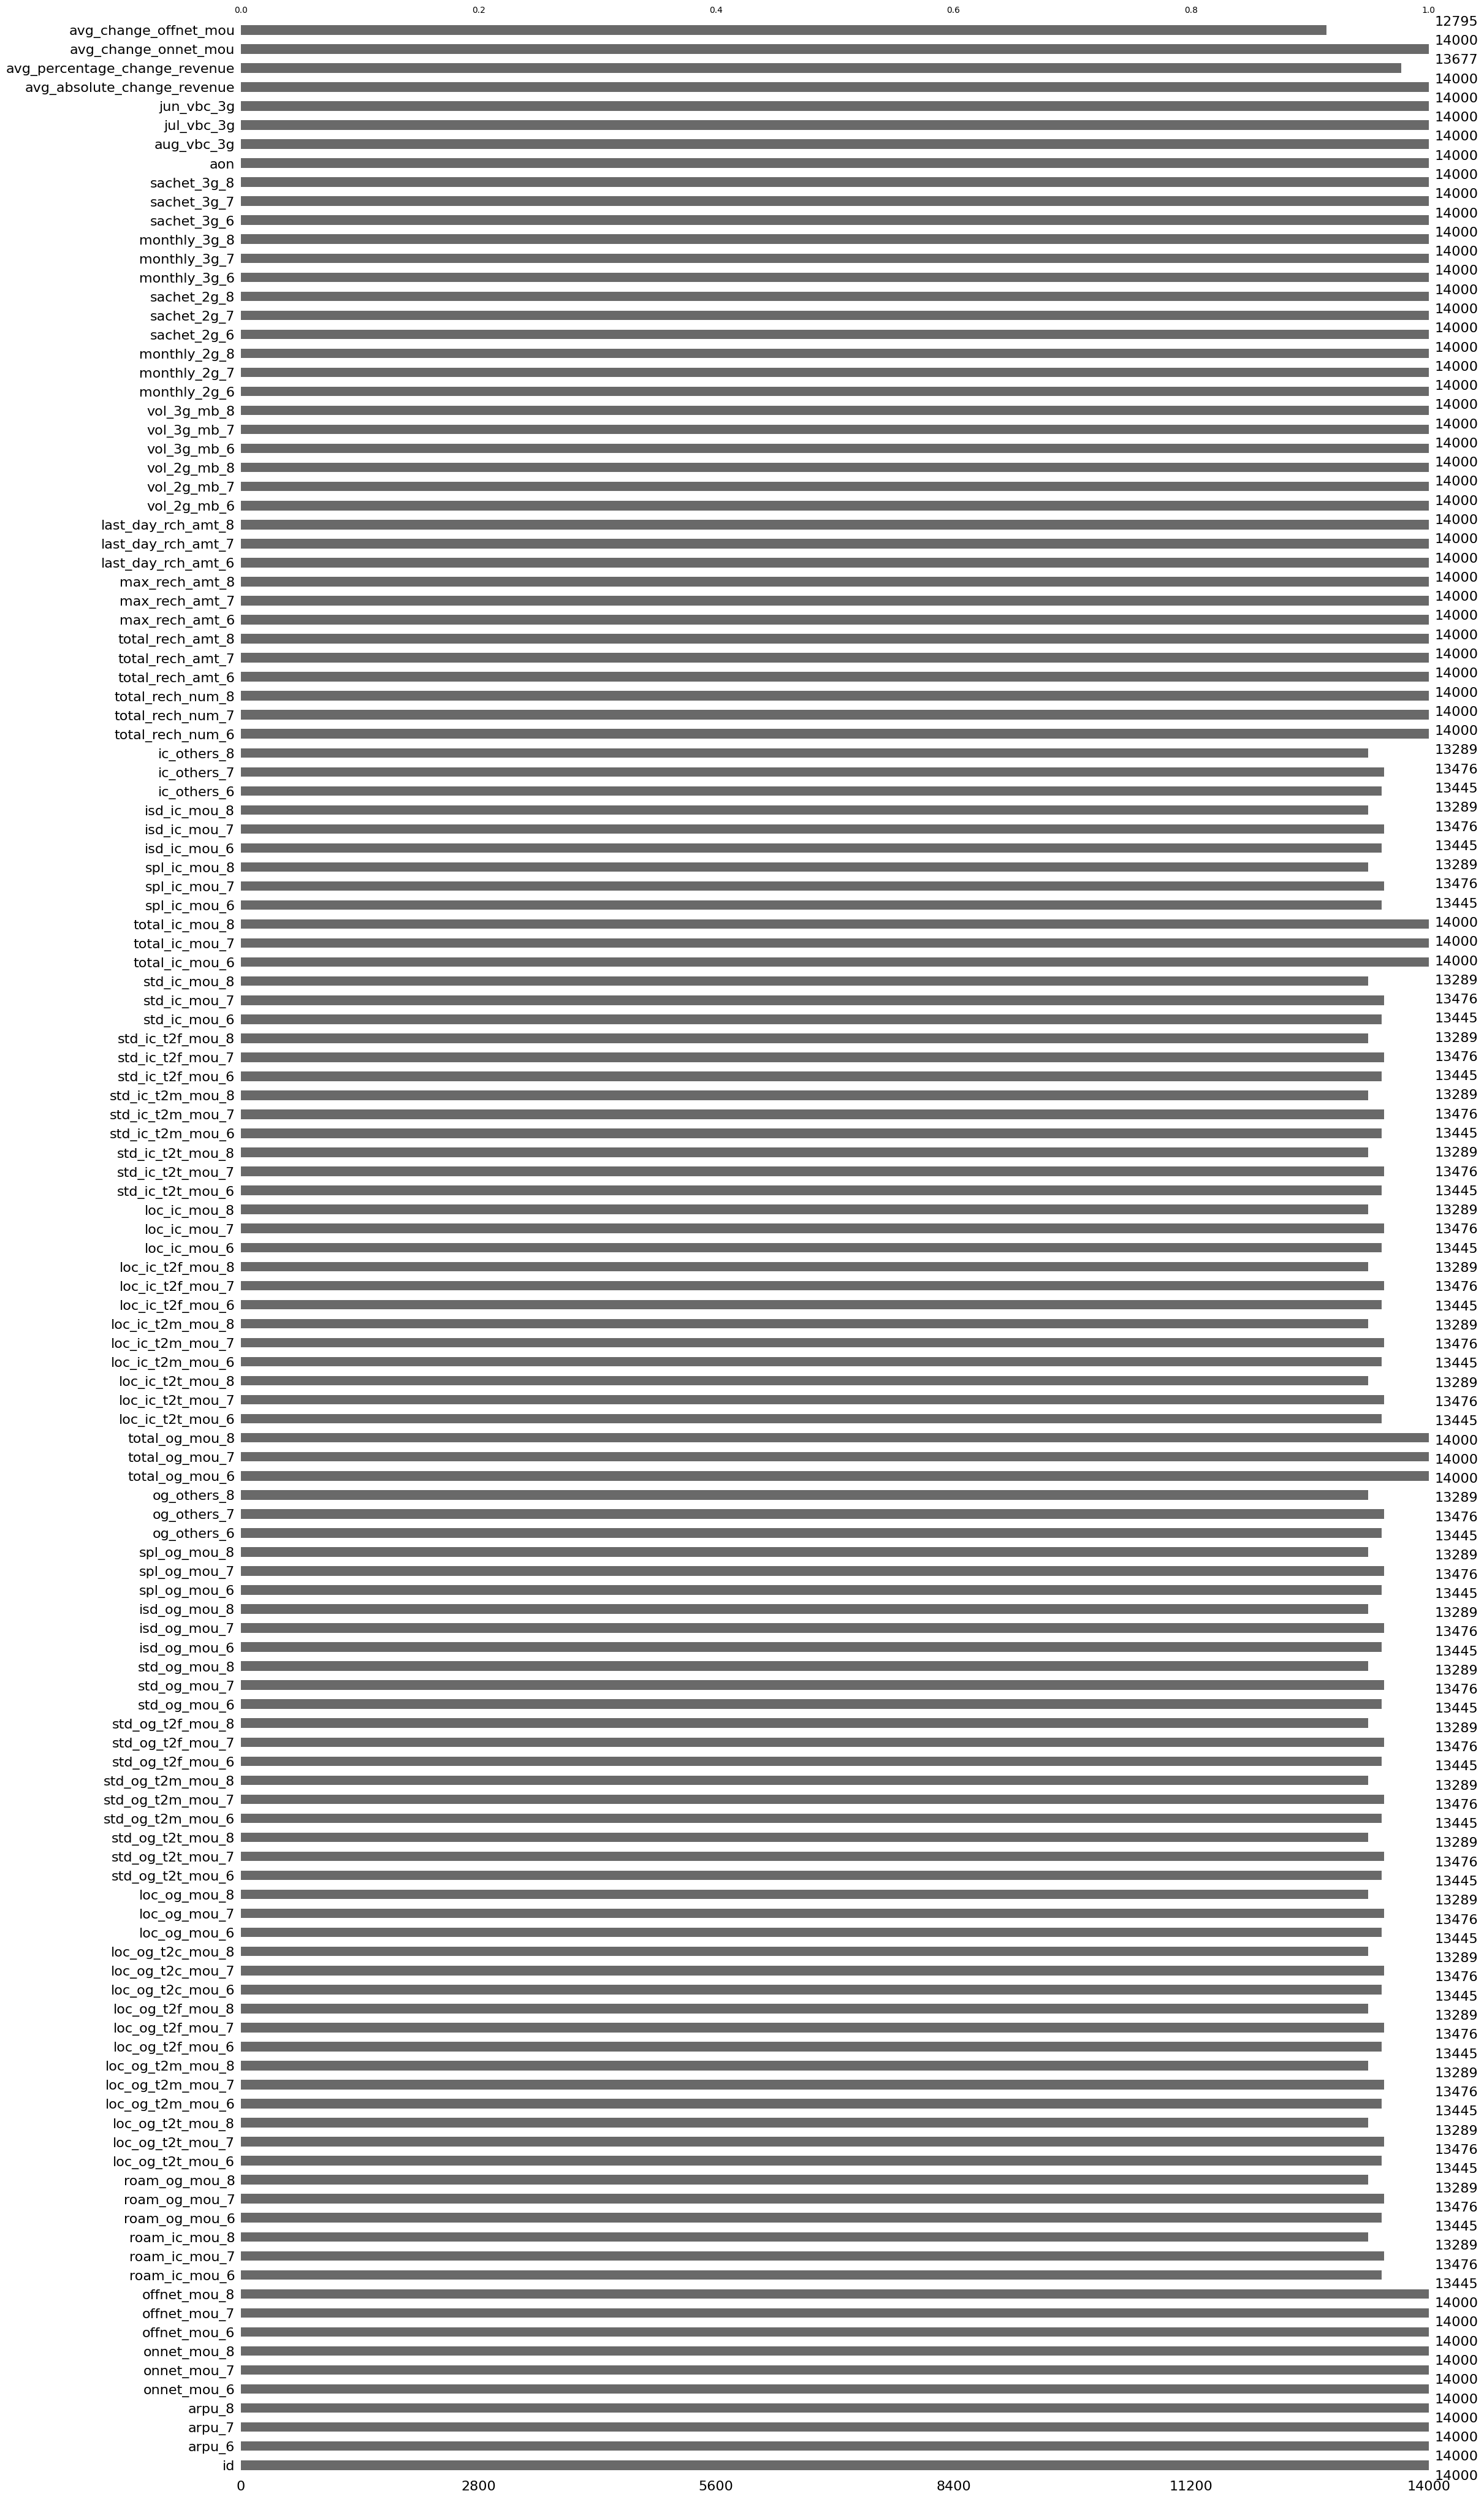

In [53]:
msno.bar(X_test)

In [54]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [55]:
# Replace infinity with NaN
X_test_filtered['avg_percentage_change_revenue'] = X_test_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = X_test_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
X_test_filtered['avg_percentage_change_revenue'] = X_train_filtered['avg_percentage_change_revenue'].fillna(median_value)


In [56]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])

<Axes: >

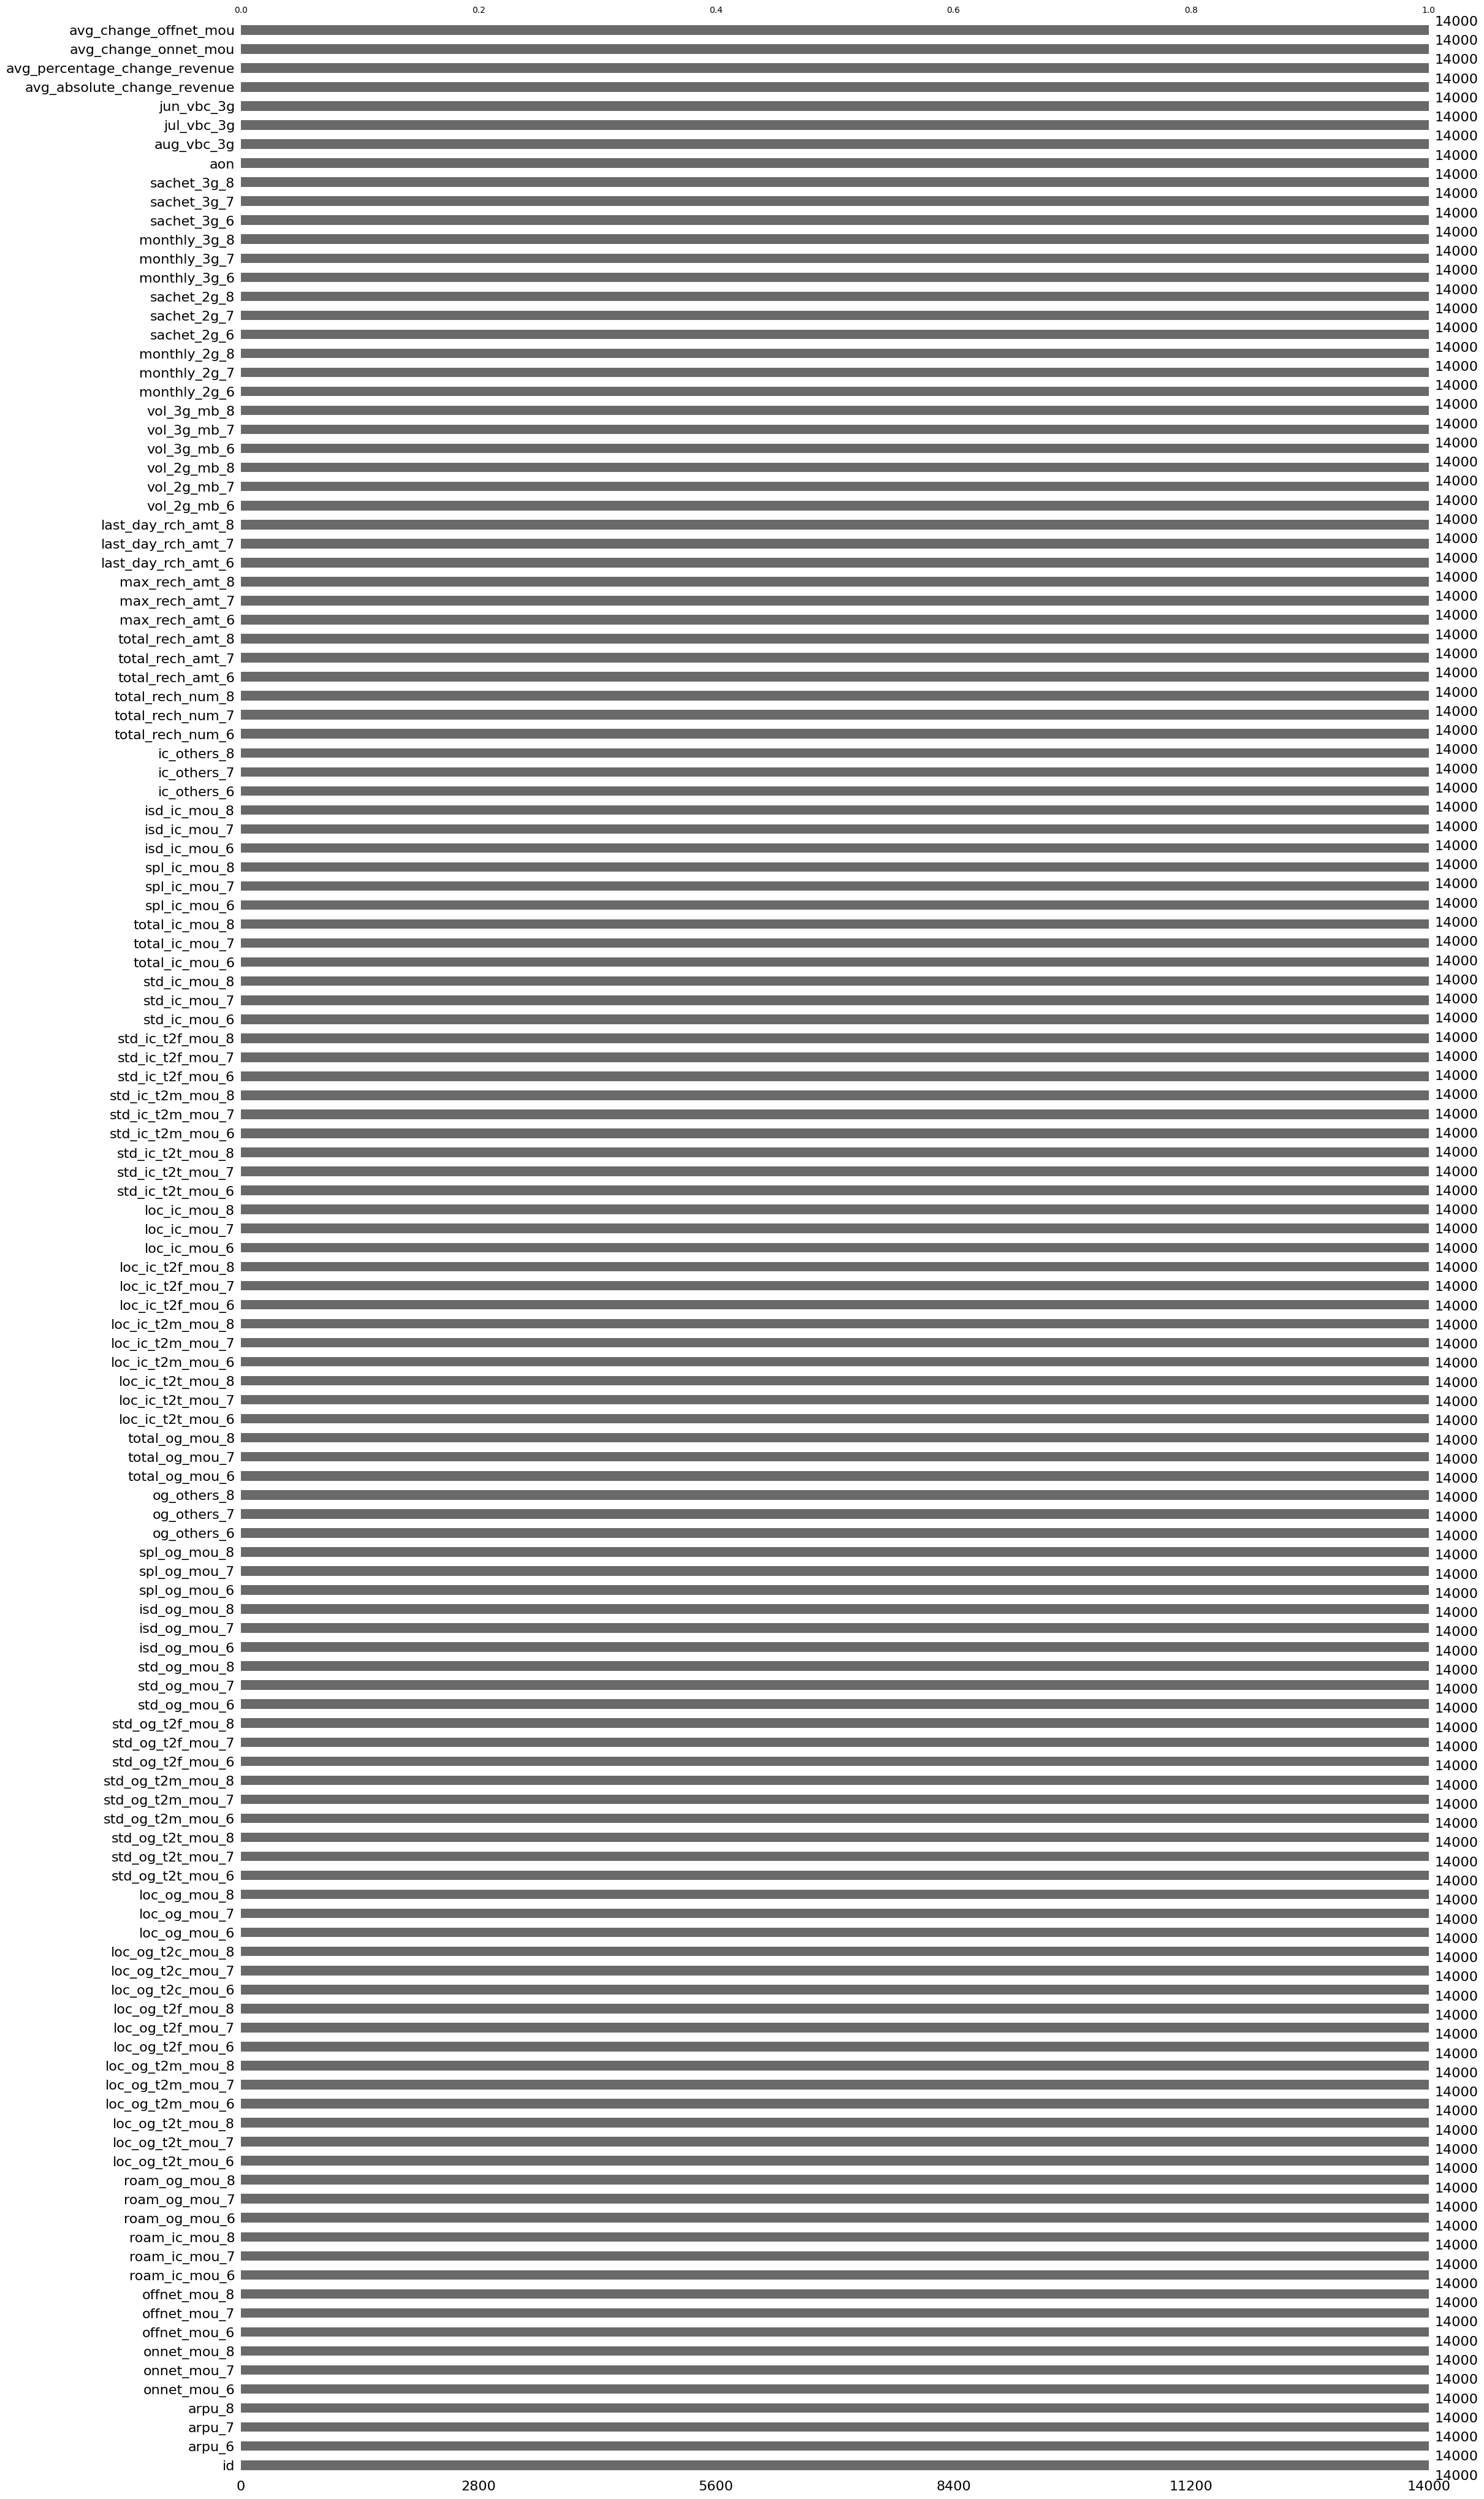

In [57]:
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

In [58]:
y_train.describe

<bound method NDFrame.describe of 40151    0
580      0
31613    0
10428    0
51502    1
        ..
10974    0
40075    0
46720    0
8593     0
27907    0
Name: churn_probability, Length: 55999, dtype: int64>

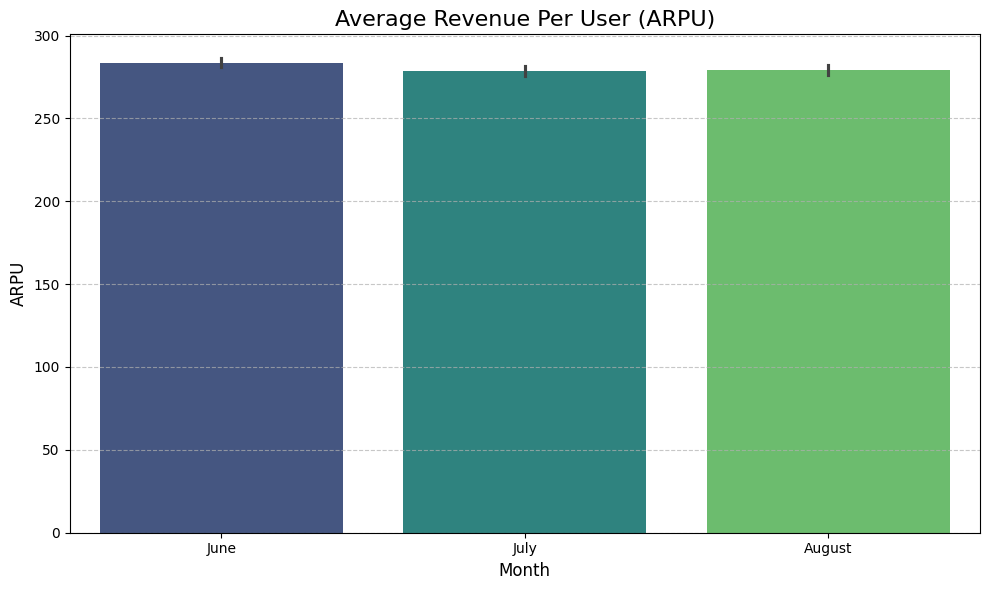

In [59]:
# Visualising Average Revenue per user
# Columns for ARPU
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
arpu_data = X_train_filtered[arpu_cols].copy()
arpu_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
arpu_long = arpu_data.melt(var_name='Month', value_name='ARPU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=arpu_long, x='Month', y='ARPU', palette='viridis')

# Customize the plot
plt.title('Average Revenue Per User (ARPU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('ARPU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()





In [60]:
# It appears that revenue is relatively stable month on month

### Visualising total outgoing minutes of usage

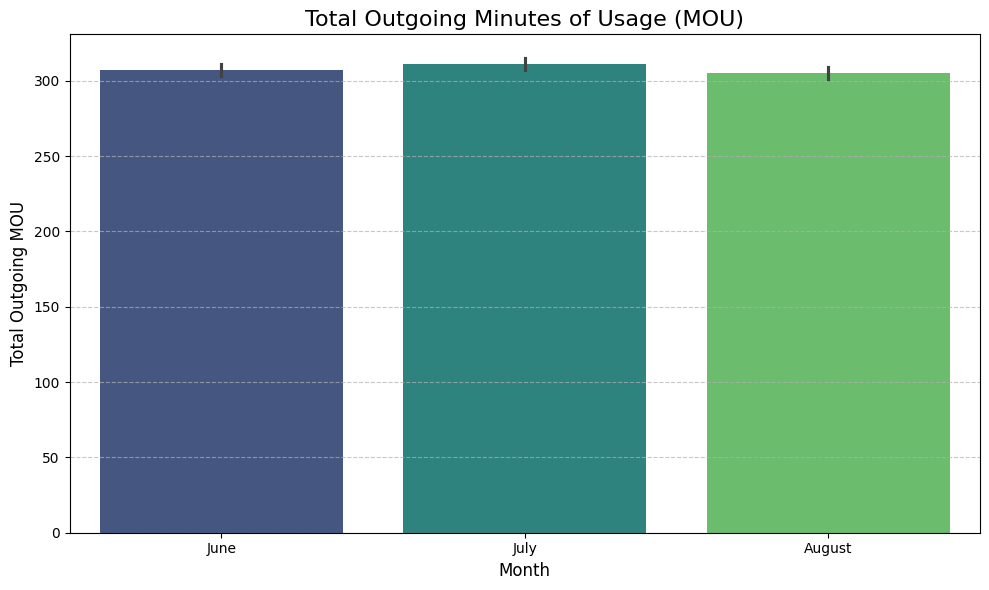

In [61]:
# Columns for total outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
mou_data = X_train_filtered[total_og_mou_cols].copy()
mou_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
mou_long = mou_data.melt(var_name='Month', value_name='Total Outgoing MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=mou_long, x='Month', y='Total Outgoing MOU', palette='viridis')

# Customize the plot
plt.title('Total Outgoing Minutes of Usage (MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Outgoing MOU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Outgoing minutes of usage appears relatively stable

### Visualizing calls made outside the operator network

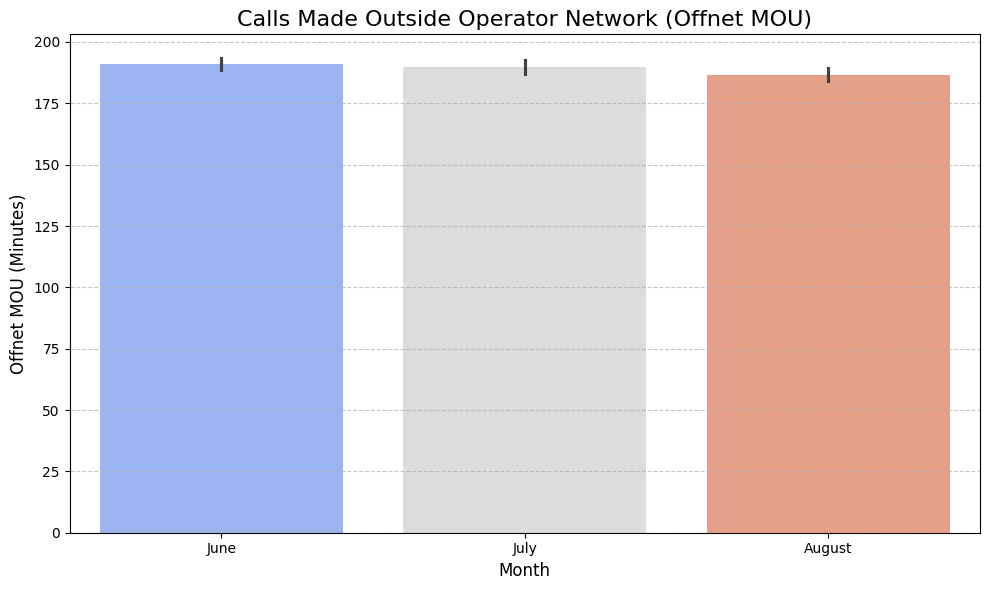

In [62]:
# Columns for calls made outside the operator network
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
offnet_data = X_train_filtered[offnet_mou_cols].copy()
offnet_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
offnet_long = offnet_data.melt(var_name='Month', value_name='Offnet MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=offnet_long, x='Month', y='Offnet MOU', palette='coolwarm')

# Customize the plot
plt.title('Calls Made Outside Operator Network (Offnet MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Offnet MOU (Minutes)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
# calls made outside the operator network appear relatively stable

### 4.3 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [64]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

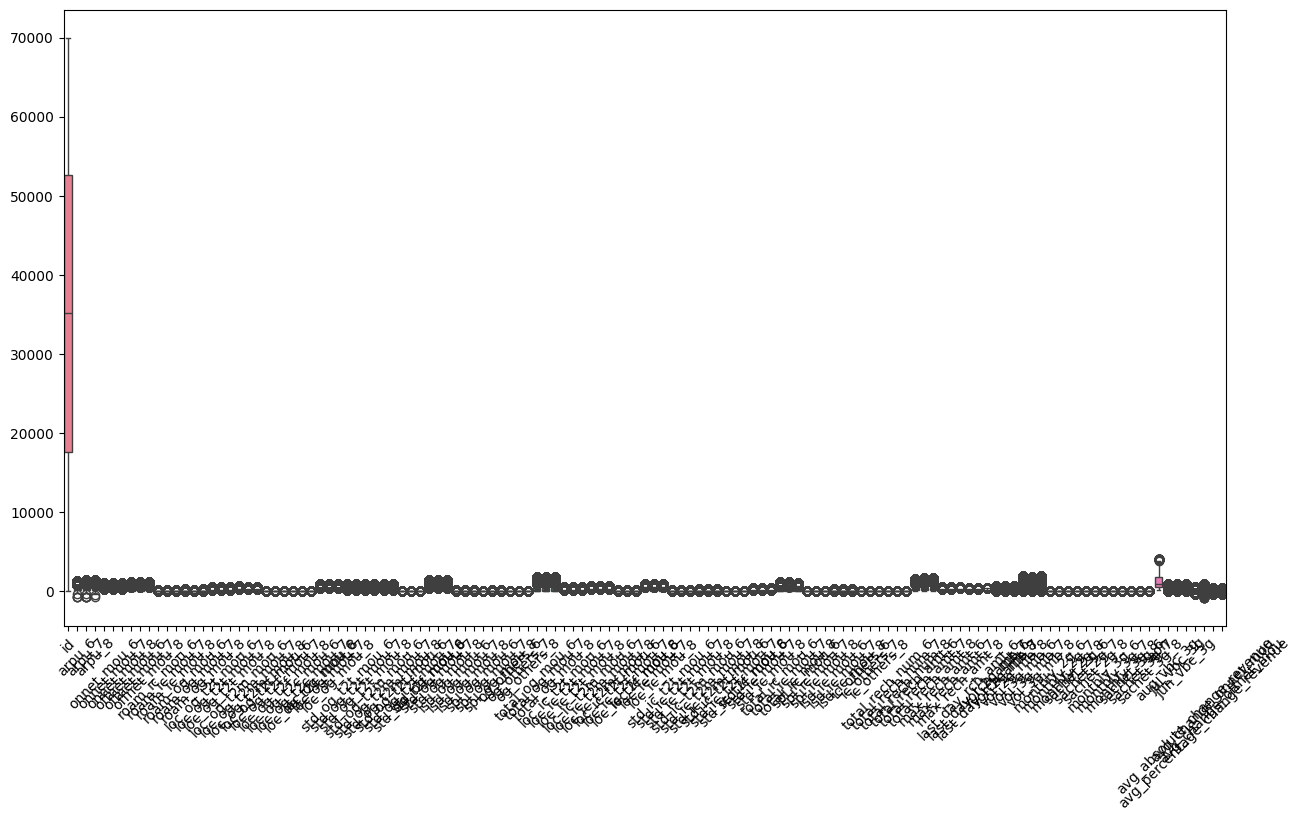

In [65]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.4 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [66]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [67]:
X_train_filtered1.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
40151  40151  108.208  133.066  359.323        12.41        18.98   
580      580  225.510  317.162  313.344        76.64       126.16   
31613  31613   29.255  101.752  360.463        11.04        12.03   
10428  10428   -5.000  518.882  537.677         0.00       564.18   
51502  51502  610.774  637.067    0.000       993.18       702.88   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
40151        50.24         85.26         93.53        279.86  ...   
580         142.16        127.26        288.94        248.94  ...   
31613        22.98         14.29         72.86        167.89  ...   
10428       735.28          0.00        423.44        306.18  ...   
51502         0.00        340.88        437.41          0.00  ...   

       sachet_3g_7  sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
40151          0.0          0.0   679.0        0.00         0.0         0.0   
580            0.0          0.0  2224.0        0.00         0.0         0.0   
31613          0.0          0.0  1364.0        0.00         0.0         0.0   
10428          0.0          0.0  1035.0        7.12         0.0         0.0   
51502          0.0          0.0   597.0        0.00         0.0         0.0   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
40151                     125.5575                       0.965030   
580                        43.9170                       0.197191   
31613                     165.6040                       2.510335   
10428                     271.3385                     -52.370089   
51502                    -305.3870                      -0.478476   

       avg_change_onnet_mou  avg_change_offnet_mou  
40151             18.915000                  97.30  
580               32.760000                  60.84  
31613              5.970000                  76.80  
10428            367.640000                   0.00  
51502           -411.030882                   0.00  

[5 rows x 129 columns]

<Axes: >

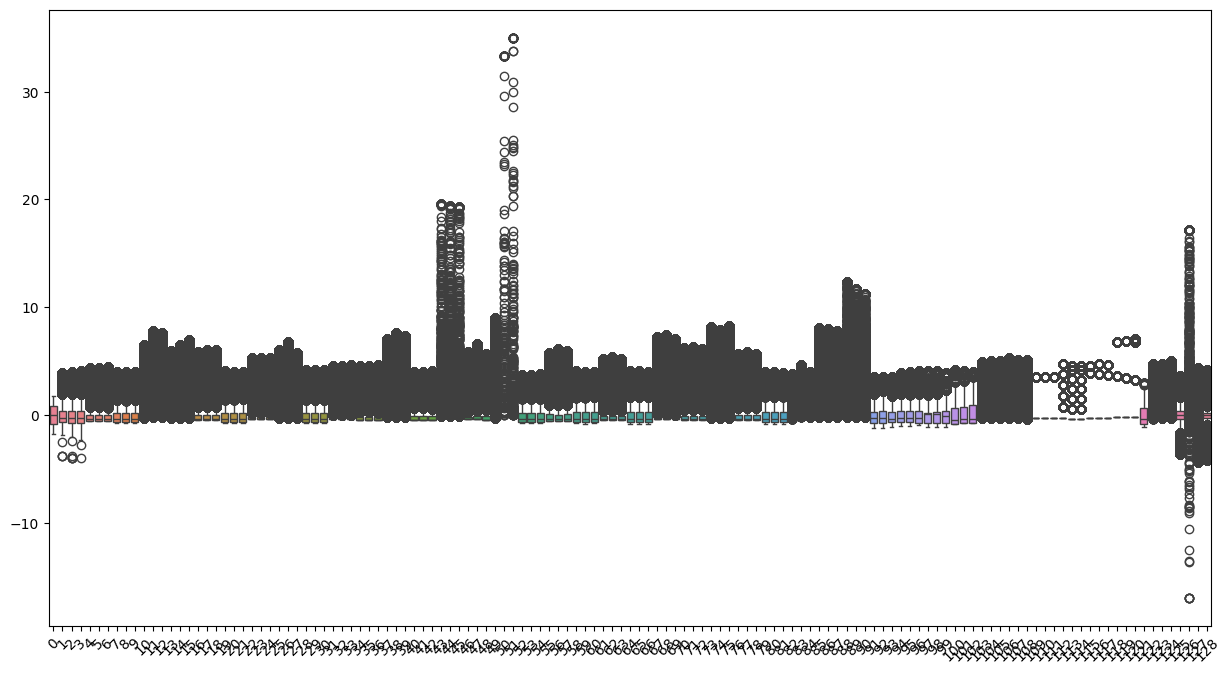

In [68]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2))

In [69]:
updated_cols = X_train_filtered.columns


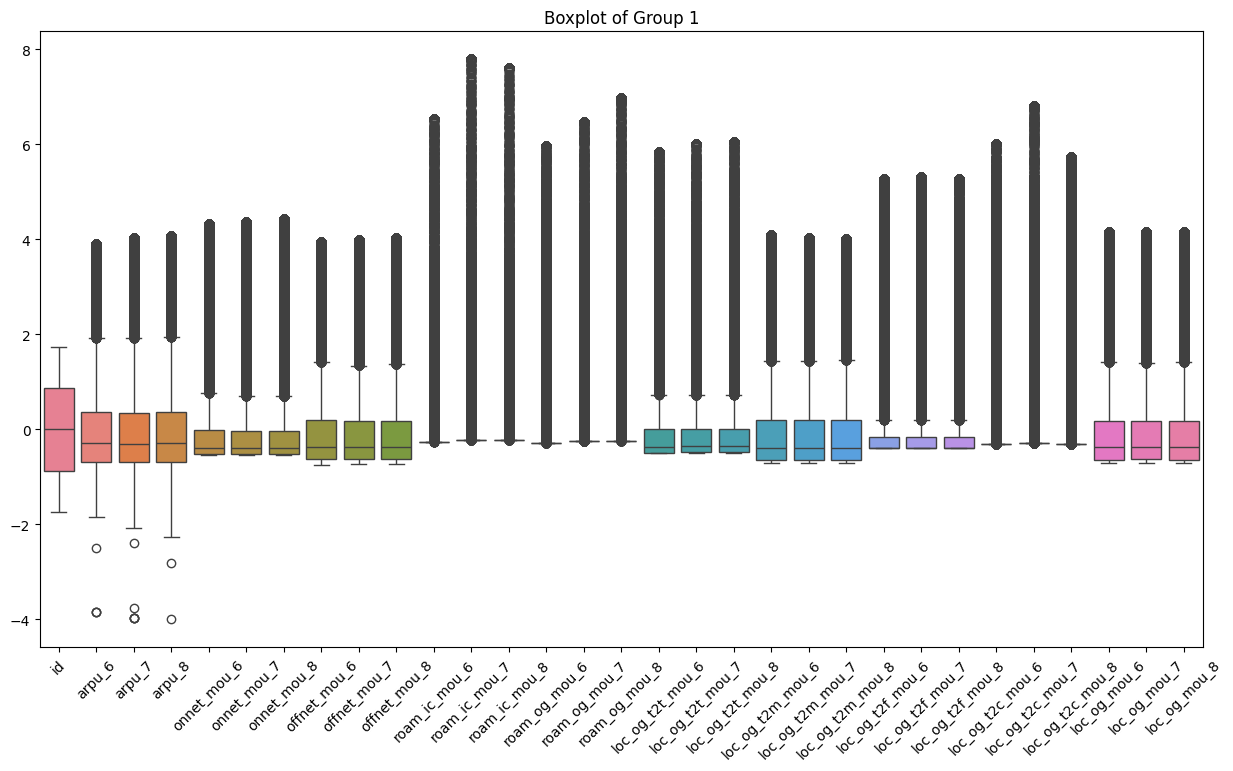

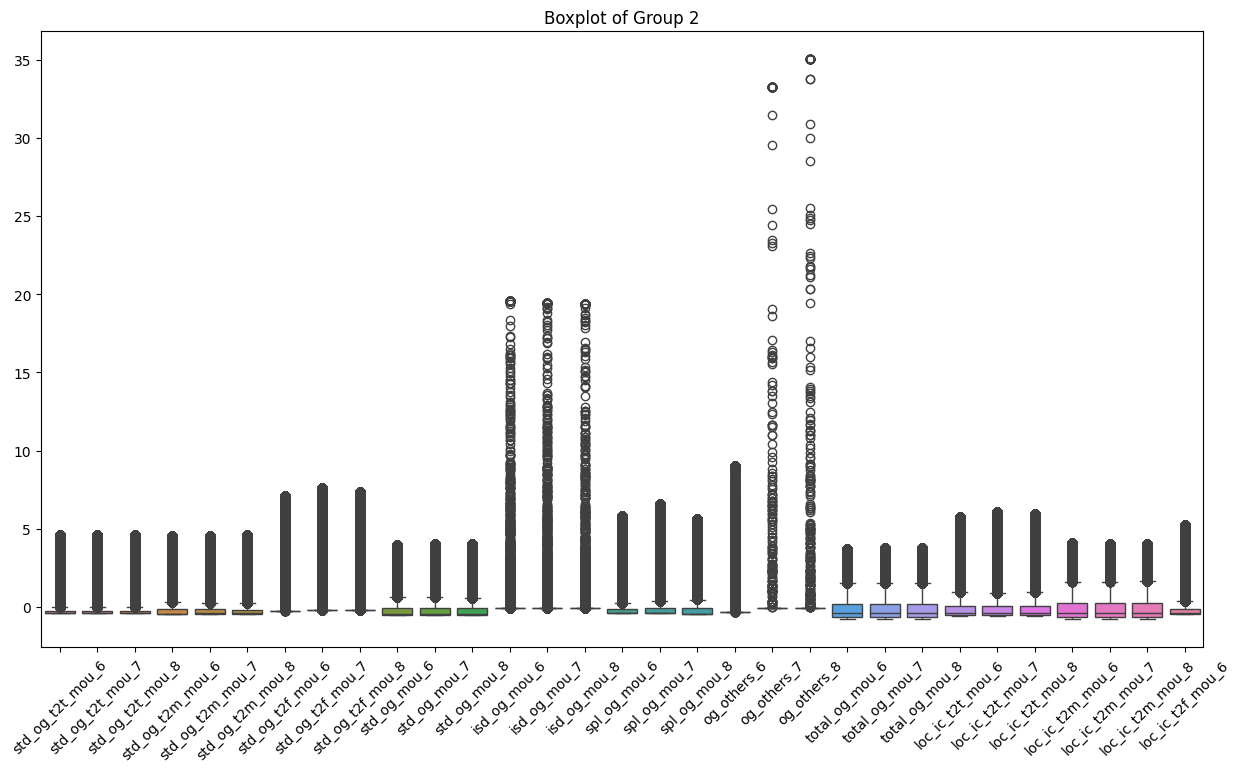

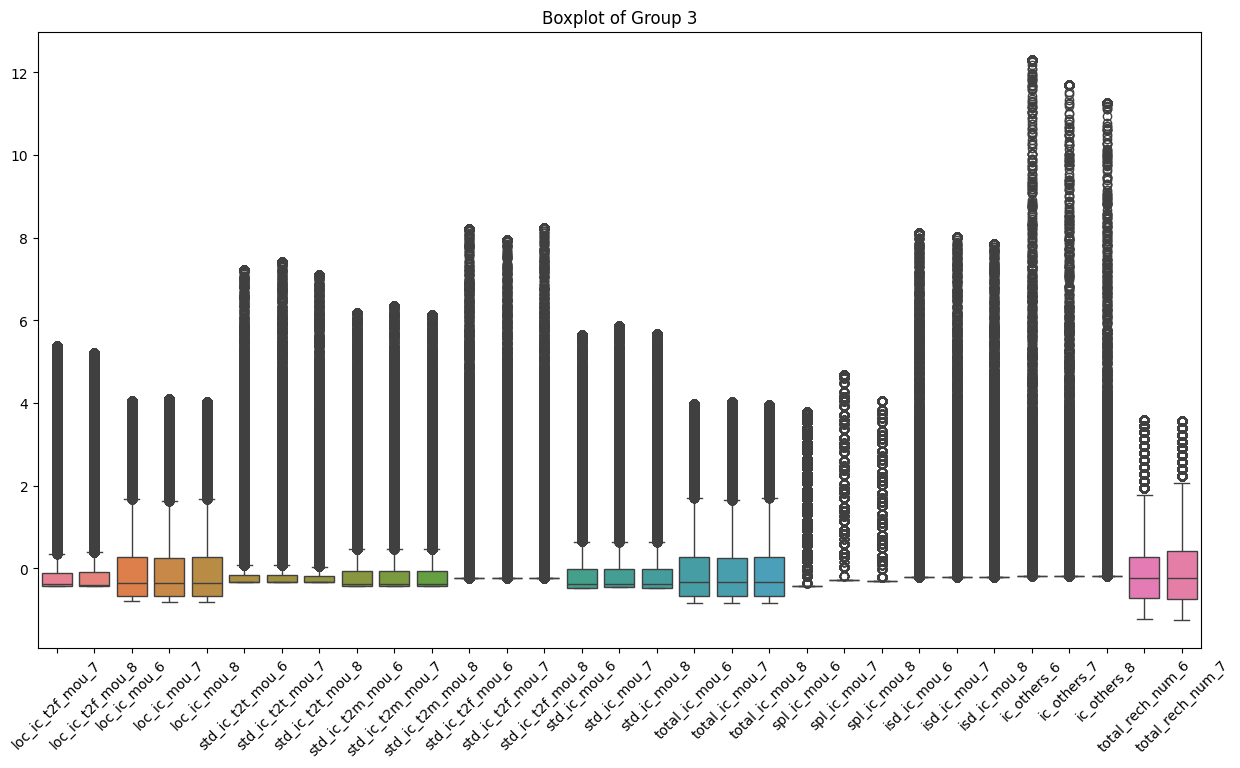

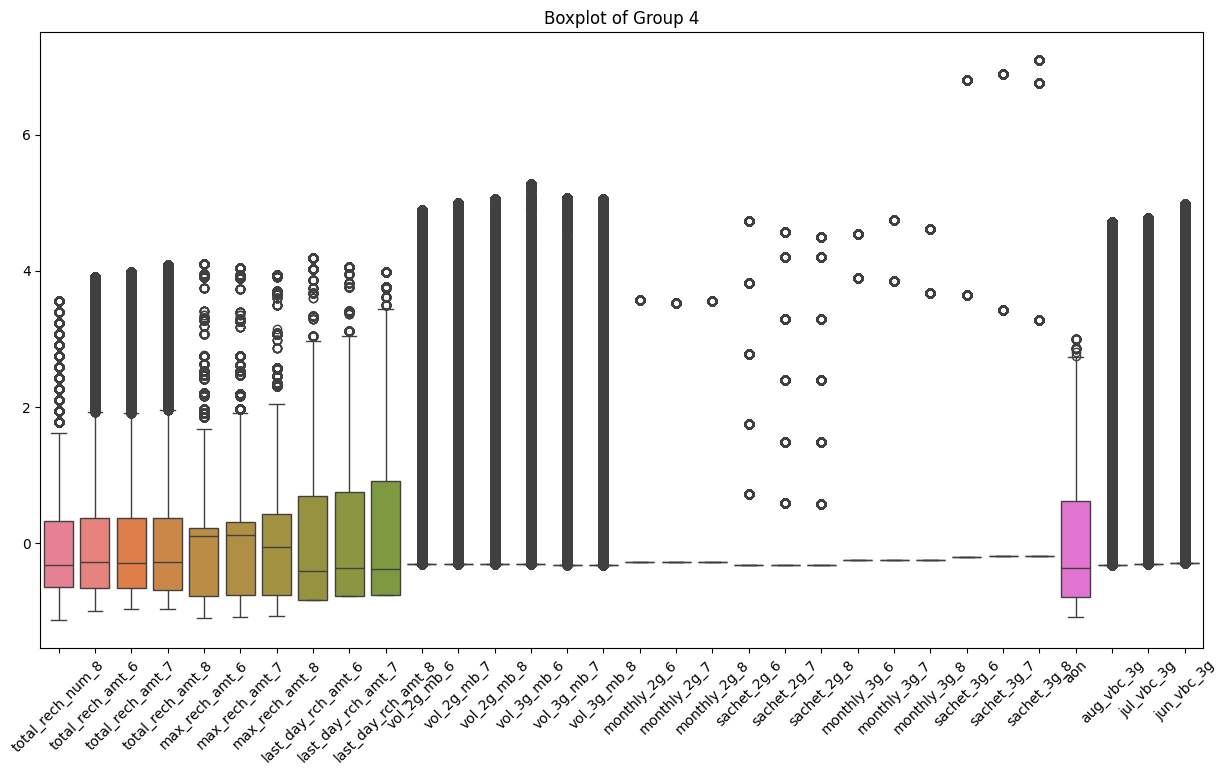

In [70]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=updated_cols)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

### 4.5 SMOTE to fix imbalance in chun probability

<Axes: xlabel='churn_probability', ylabel='Count'>

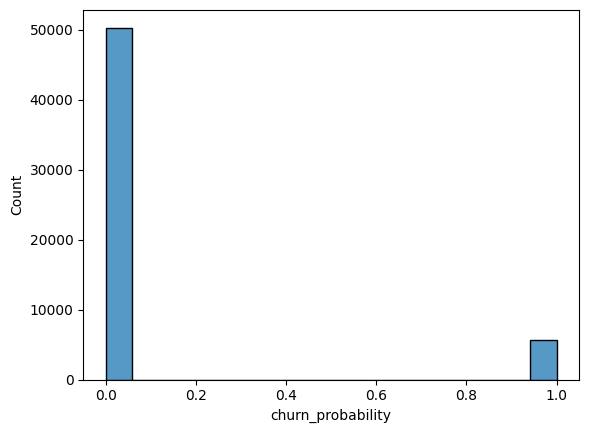

In [71]:
#Distribution for the churn probability
sns.histplot(y_train)

In [72]:
print("Shape of X_train_filtered2:", X_train_filtered2.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_filtered2: (55999, 129)
Shape of y_train: (55999,)


In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
smt = SMOTE(random_state=2)
X_train_filtered2, y_train = smt.fit_resample(X_train_filtered2, y_train)

<Axes: xlabel='churn_probability', ylabel='Count'>

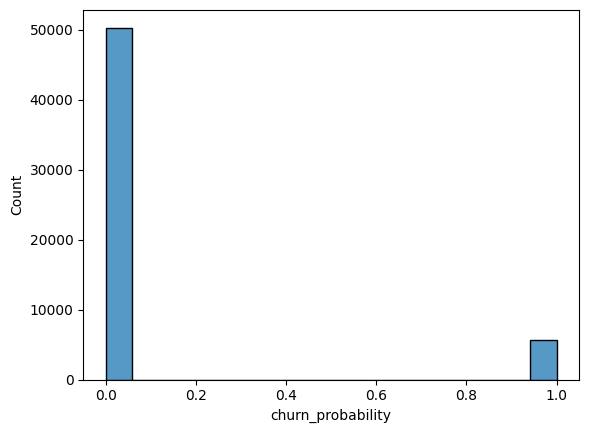

In [74]:
#Distribution for the churn probability
sns.histplot(y_train)

### Selecting Features with RFE

In [ ]:
print(X_train_filtered2.shape)
print(y_train.shape)


In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  # specify n_features_to_select as a keyword argument
rfe = rfe.fit(X_train_filtered2, y_train)
print(rfe.support_)  # Print the boolean results


[False False False False False False False  True False False False False
 False False False False False False  True False False  True False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
  True False False  True False  True  True False False False False False
 False False False  True False False False False False False False False
  True False False False False False False False False  True False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]


In [77]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('id', False, 116),
 ('arpu_6', False, 19),
 ('arpu_7', False, 6),
 ('arpu_8', False, 14),
 ('onnet_mou_6', False, 48),
 ('onnet_mou_7', False, 43),
 ('onnet_mou_8', False, 46),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', False, 32),
 ('offnet_mou_8', False, 3),
 ('roam_ic_mou_6', False, 85),
 ('roam_ic_mou_7', False, 44),
 ('roam_ic_mou_8', False, 107),
 ('roam_og_mou_6', False, 74),
 ('roam_og_mou_7', False, 104),
 ('roam_og_mou_8', False, 8),
 ('loc_og_t2t_mou_6', False, 50),
 ('loc_og_t2t_mou_7', False, 31),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 41),
 ('loc_og_t2m_mou_7', False, 30),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 52),
 ('loc_og_t2f_mou_7', False, 93),
 ('loc_og_t2f_mou_8', False, 97),
 ('loc_og_t2c_mou_6', False, 61),
 ('loc_og_t2c_mou_7', False, 83),
 ('loc_og_t2c_mou_8', False, 78),
 ('loc_og_mou_6', False, 27),
 ('loc_og_mou_7', False, 12),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 60),
 ('std_og_t2t_mou_7',

In [78]:
col = X_train.columns[rfe.support_]

In [79]:
# Variables selected by RFE 
print(col)

Index(['offnet_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8'],
      dtype='object')


##### Assessing the model with StatsModels

In [80]:
# plt.figure(figsize=(10,8))
# sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

In [ ]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_filtered2, y_train)

In [ ]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
import statsmodels.api as sm
logm4 = sm.GLM(y_train,(sm.add_constant(X_train_filtered2)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

### we need to drop variables with high p-value and cross-correlation

In [ ]:
X_test.describe

In [ ]:
# X_test[col].shape
# #res = modres.predict(X_test[col])

### Making Predictions with RFE

In [ ]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_filtered)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

In [ ]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

In [ ]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns using reindex
y_pred_final = y_pred_final.reindex(columns=['CustID', 'churn_probability', 'Churn_Prob'])

# Let's see the head of y_pred_final
y_pred_final.head()


In [ ]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

### RFE Model Evaluation

In [ ]:
from sklearn import metrics

In [ ]:
print(y_pred_final.isnull().sum())


In [ ]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn_probability , y_pred_final.predicted )
confusion

In [ ]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.predicted)

In [ ]:


# converting to data frame, in order to extract columns
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)


#### Supriyo - could you start PCA here

In [1]:
from sklearn.decomposition import PCA

In [2]:
pca = PCA(random_state=42)

In [77]:
# Display the data types of each column
print(X_train_filtered.dtypes)

id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [78]:
columns_having_null = X_train_filtered.columns[X_train_filtered.isnull().sum()>0]
print(columns_having_null)

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [79]:
X_train_filtered[columns_having_null] =X_train_filtered[columns_having_null].fillna(0)
print(X_train_filtered.isnull().sum())


id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jun_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 129, dtype: int64


In [80]:
pca.fit(X_train_filtered)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [42]:
#Segregating the train data for high value customers
## This needs to be done before Scaling ....
X_train_filtered.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [43]:
X_train_filtered.shape

(55999, 125)

In [44]:
X_train_filtered.shape

(55999, 125)

In [45]:
y_train.value_counts()

0    50302
1     5697
Name: churn_probability, dtype: int64

In [46]:
y_test.value_counts()

0    12565
1     1435
Name: churn_probability, dtype: int64

<Axes: xlabel='churn_probability', ylabel='Count'>

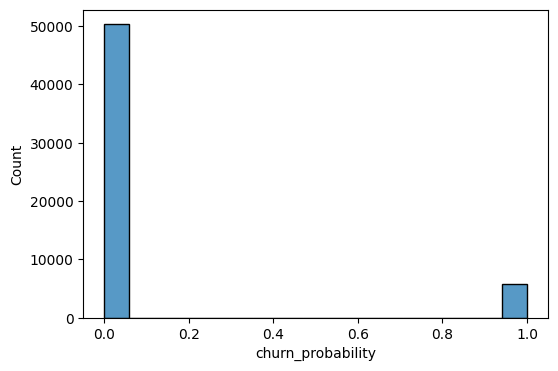

In [47]:
#Distribution for the churn probability
plt.figure(figsize=(6, 4))
sns.histplot(y_train)

In [50]:
from imblearn.over_sampling import SMOTE

In [52]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)


(100604, 125)
(100604,)
